# Intraday LightGBM on Binance minute bars
This notebook:
1. Downloads 1m OHLCV from Binance.
2. Builds features and a forward-return label.
3. Runs walk-forward training.
4. Backtests a threshold policy with costs.

In [1]:
# %pip install -q -r ../requirements.txt

In [36]:
# make project importable
import sys, os, pandas as pd, numpy as np
sys.path.insert(0, os.path.abspath(".."))

from requests import HTTPError
import src.binance_downloader as bd
from src.binance_downloader import fetch_klines

def to_utc(ts: pd.Timestamp) -> pd.Timestamp:
    """Return a UTC-aware Timestamp whether input is naive or tz-aware."""
    ts = pd.Timestamp(ts)
    return ts.tz_localize("UTC") if ts.tz is None else ts.tz_convert("UTC")

def fetch_with_fallback(symbol, interval, start, end):
    """
    Try Binance global, then Binance US if geofenced (451/403) or empty.
    Returns (df, host_used).
    """
    hosts = [
        "https://api.binance.com/api/v3/klines",
        "https://api.binance.us/api/v3/klines",
    ]
    last_err = None
    for host in hosts:
        try:
            bd.BASE = host  # switch endpoint used by fetch_klines
            df = fetch_klines(symbol, interval, start, end)
            if len(df) > 0:
                return df, host
        except HTTPError as e:
            last_err = e
            code = getattr(e.response, "status_code", None)
            if code in (451, 403):
                continue  # try next host
            else:
                continue
        except Exception as e:
            last_err = e
            continue
    if last_err:
        raise last_err
    raise RuntimeError("All endpoints returned empty data.")


In [37]:
# config for this run (adjust dates if you want)
SYMBOL = "BTCUSDT"
INTERVAL = "1m"

END = pd.Timestamp.utcnow().floor("min")
START = END - pd.Timedelta(days=14)

start_utc = to_utc(START)
end_utc   = to_utc(END)

print(f"Downloading {SYMBOL} {INTERVAL} from {start_utc} to {end_utc} ...")
try:
    df, host = fetch_with_fallback(SYMBOL, INTERVAL, start_utc, end_utc)
    for c in ["open","high","low","close","volume"]:
        df[c] = df[c].astype(float)
    print(f"Bars: {len(df)}  |  Source: {host}")
except Exception as e:
    print("Download failed or empty:", repr(e), "\nGenerating synthetic series so you can proceed.")
    idx = pd.date_range(start_utc, end_utc, freq="1min", inclusive="left")
    price = 30000 + np.cumsum(np.random.normal(0, 10, len(idx)))
    df = pd.DataFrame(
        {
            "open":  price + np.random.normal(0, 1, len(idx)),
            "high":  price + np.random.uniform(0, 5, len(idx)),
            "low":   price - np.random.uniform(0, 5, len(idx)),
            "close": price + np.random.normal(0, 1, len(idx)),
            "volume": np.abs(np.random.normal(100, 20, len(idx))),
            "number_of_trades": np.random.randint(50, 150, len(idx)),
        },
        index=idx,
    )
    print("Synthetic bars:", len(df))

# ensure UTC-aware index for downstream feature code
if df.index.tz is None:
    df.index = df.index.tz_localize("UTC")

df.head()


Bars: 20161  |  Source: https://api.binance.us/api/v3/klines


,open,high,low,close,volume,number_of_trades
open_time,,,,,,
2025-08-23 18:32:00+00:00,115211.88,115211.88,115211.88,115211.88,0.00000,0
2025-08-23 18:33:00+00:00,115651.91,115651.94,115651.91,115651.94,0.00237,3
2025-08-23 18:34:00+00:00,115651.49,115651.50,115651.49,115651.50,0.00135,2
2025-08-23 18:35:00+00:00,115650.98,115651.07,115211.95,115211.95,0.00219,4
2025-08-23 18:36:00+00:00,115650.92,115650.92,115212.04,115212.04,0.00489,5


In [38]:
from src.feature_engineering import build_features, make_labels
from src.utils import bps_to_frac

HORIZON_MIN = 5
COST_BPS = 3

fdf = build_features(
    df,
    rsi_periods=(7, 14),
    macd=(12, 26, 9),
    atr_period=14,
    vol_windows=(5, 15, 60),
    vwap_windows=(5, 15, 60),
)

# makes classification label and forward return
fdf = make_labels(fdf, horizon_minutes=HORIZON_MIN, cost_frac=bps_to_frac(COST_BPS))

# if your index is UTC-naive for any reason, fix it here too
if fdf.index.tz is None:
    fdf.index = fdf.index.tz_localize("UTC")

fdf = fdf.dropna()
print("Feature rows after dropna:", len(fdf))
fdf.tail(3)


Feature rows after dropna: 19885


,open,high,low,close,volume,number_of_trades,ret_1,ret_5,ret_15,ret_60,...,minute_52,minute_53,minute_54,minute_55,minute_56,minute_57,minute_58,minute_59,fwd_ret,y
open_time,,,,,,,,,,,,,,,,,,,,,
2025-09-06 18:25:00+00:00,110299.66,110299.67,110299.66,110299.67,0.00045,2,-8.159586e-07,0.000305,0.001384,5.439728e-07,...,False,False,False,False,False,False,False,False,-0.000005,0
2025-09-06 18:26:00+00:00,110299.67,110299.67,110299.67,110299.67,0.00000,0,0.000000e+00,0.000305,0.001375,5.439728e-07,...,False,False,False,False,False,False,False,False,-0.000006,0
2025-09-06 18:27:00+00:00,110299.67,110299.67,110299.67,110299.67,0.00000,0,0.000000e+00,0.000305,0.000291,1.894856e-05,...,False,False,False,False,False,False,False,False,-0.001193,0


In [39]:
# === Feature list ===
import pandas as pd, numpy as np
from IPython.display import display

excluded = {"y", "fwd_ret"}
base_exclude = {"open", "high", "low", "close"}  # keep raw OHLC out of model inputs
feat_cols = [c for c in fdf.columns if c not in excluded and c not in base_exclude]
print(f"Using {len(feat_cols)} features")

# === Walk-forward training (short folds so it works with small windows) ===
from src.walkforward import WalkForwardConfig, run_walkforward

MIN_TRAIN_DAYS = 3
TEST_WINDOW_DAYS = 1
EMBARGO_MIN = 10

wf_cfg = WalkForwardConfig(
    test_window_days=TEST_WINDOW_DAYS,
    min_train_days=MIN_TRAIN_DAYS,
    embargo_minutes=EMBARGO_MIN,
    features=feat_cols,
    target_col="y",
)

res = run_walkforward(fdf, wf_cfg)
print("num folds:", len(res["models"]))
display(res["metrics"] if len(res["models"]) else pd.DataFrame())

# === Attach predictions (fallback to a simple holdout if no folds) ===
from lightgbm import LGBMClassifier

try:
    HORIZON_MIN
except NameError:
    HORIZON_MIN = 5
try:
    COST_BPS
except NameError:
    COST_BPS = 3

if len(res["models"]) == 0:
    print("No folds from walk-forward. Falling back to a simple 70/30 time split.")
    cutoff = fdf.index.min() + (fdf.index.max() - fdf.index.min()) * 0.7
    mask = fdf.index <= cutoff
    X = fdf[feat_cols]
    y = fdf["y"]
    model = LGBMClassifier(
        n_estimators=400,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
    )
    model.fit(X[mask], y[mask])
    proba = pd.Series(np.nan, index=fdf.index, name="proba")
    proba.loc[~mask] = model.predict_proba(X[~mask])[:, 1]
    fdf = fdf.join(proba)
else:
    fdf = fdf.join(res["oof_pred"].rename("proba"))

# === Backtest ===
from src.backtest import backtest_long_short

LONG_TH = 0.55
SHORT_TH = 0.0          # start long-only; set <0.5 to allow shorts
SLIP_BPS = 2

bt, metr = backtest_long_short(
    fdf.dropna(subset=["proba", "fwd_ret"]),
    proba_col="proba",
    long_threshold=float(LONG_TH),
    short_threshold=float(SHORT_TH),
    cost_bps=int(COST_BPS),
    slippage_bps=int(SLIP_BPS),
    horizon_minutes=int(HORIZON_MIN),
)

print(metr)
bt.head(3)


Using 89 features
[LightGBM] [Info] Number of positive: 746, number of negative: 2346
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001072 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7180
[LightGBM] [Info] Number of data points in the train set: 3092, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.241268 -> initscore=-1.145741
[LightGBM] [Info] Start training from score -1.145741
[LightGBM] [Info] Number of positive: 1131, number of negative: 3382
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7214
[LightGBM] [Info] Number of data points in the train set: 4513, number of used features: 89
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.250609 -> initscore=-

,fold,AUC,Acc,F1,Precision,Recall,n_train,n_test
0,1,0.712075,0.714989,0.439834,0.469027,0.414062,3092,1421
1,2,0.777772,0.797917,0.379531,0.626761,0.272171,4513,1440
2,3,0.683919,0.730823,0.325175,0.415179,0.267241,5953,1434
3,4,0.700607,0.730203,0.403101,0.477941,0.348525,7387,1427
4,5,0.774864,0.788301,0.353191,0.528662,0.265176,8814,1436
5,6,0.802411,0.785112,0.388000,0.466346,0.332192,10250,1424
6,7,0.674703,0.688502,0.339734,0.413669,0.288221,11674,1435
7,8,0.664495,0.690693,0.380952,0.422360,0.346939,13109,1429
8,9,0.705526,0.725180,0.302920,0.387850,0.248503,14538,1390
9,10,0.759493,0.745763,0.345455,0.448113,0.281065,15928,1416


{'Sharpe_like': 38.30019082222838, 'MaxDD': -0.06367563658285758, 'Turnover_per_bar': 0.10611928737412858, 'TotalBars': 16783, 'FinalEquity': 4.5203939296202975}


,open,high,low,close,volume,number_of_trades,ret_1,ret_5,ret_15,ret_60,...,minute_56,minute_57,minute_58,minute_59,fwd_ret,y,proba,pos,pnl,equity
open_time,,,,,,,,,,,,,,,,,,,,,
2025-08-26 00:10:00+00:00,109601.16,109601.16,109601.16,109601.16,0.00001,1,9.123995e-07,-0.004277,-0.007229,-0.006719,...,False,False,False,False,-3.211696e-05,0,0.922532,1,-3.211696e-05,0.999968
2025-08-26 00:11:00+00:00,109597.66,109597.67,109597.66,109597.67,0.00359,2,-3.184324e-05,-0.004296,-0.007261,-0.002945,...,False,False,False,False,-1.824856e-07,0,0.940678,1,-1.824856e-07,0.999968
2025-08-26 00:12:00+00:00,109991.09,109991.09,109597.65,109597.65,0.02012,6,-1.824856e-07,-0.004297,-0.007236,-0.002945,...,False,False,False,False,3.145571e-03,1,0.983319,1,3.145571e-03,1.003113


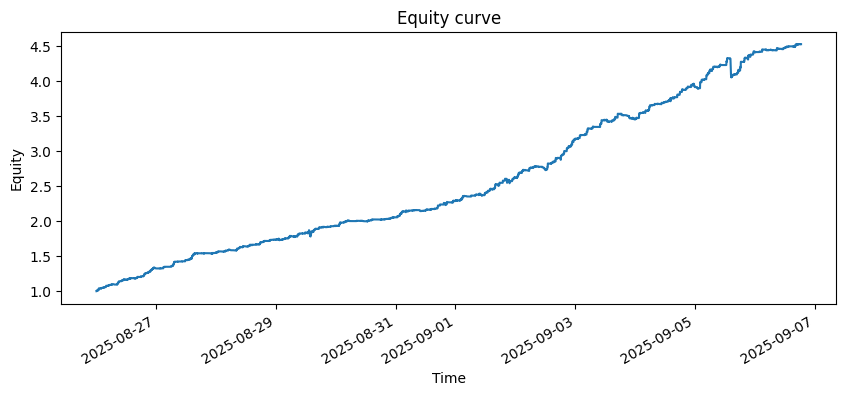

In [40]:
import matplotlib.pyplot as plt

series = bt["equity"] if bt is not None and len(bt) else None
if series is None or len(series) == 0:
    print("Backtest is empty. Increase date range or reduce fold sizes.")
else:
    plt.figure(figsize=(10, 4))
    series.plot()
    plt.title("Equity curve")
    plt.xlabel("Time"); plt.ylabel("Equity")
    plt.show()


In [41]:
for th in np.linspace(0.55, 0.65, 6):
    _, m = backtest_long_short(
        fdf.dropna(subset=["proba","fwd_ret"]),
        proba_col="proba",
        long_threshold=float(th),
        short_threshold=0.0,
        cost_bps=int(COST_BPS),
        slippage_bps=int(SLIP_BPS),
        horizon_minutes=int(HORIZON_MIN))
    print(th, m["Sharpe_like"], m["FinalEquity"])


0.55 38.30019082222838 4.5203939296202975
0.5700000000000001 35.05851740559851 3.745356802484592
0.5900000000000001 31.97323494044779 3.128336633903855
0.61 29.330569207238447 2.701521123174612
0.63 28.117773766772025 2.4957848574925277
0.65 26.10593880245397 2.2339934333900535


In [42]:
import numpy as np, pandas as pd
from src.utils import bps_to_frac

def backtest_fixed_horizon(df: pd.DataFrame,
                           proba_col: str,
                           long_threshold: float = 0.55,
                           short_threshold: float = 0.0,
                           cost_bps: int = 3,
                           slippage_bps: int = 2,
                           hold_minutes: int = 5):
    """
    Event-driven backtest:
      - enter on threshold cross when FLAT
      - hold for exactly `hold_minutes` bars
      - exit to FLAT, pay costs on entry & exit
      - PnL accrues using 1-minute log returns while holding
    """
    close = df["close"].astype(float)
    ret1 = np.log(close).diff().fillna(0.0)

    n = len(df)
    pos = np.zeros(n, dtype=int)        # -1/0/+1 position for each bar
    holding = 0                         # bars remaining in current position
    current_pos = 0

    # one-way cost (tx + slippage)
    one_way_cost = bps_to_frac(cost_bps) + bps_to_frac(slippage_bps)

    # iterate bars
    for i in range(n):
        p = df[proba_col].iloc[i]

        if holding == 0:
            # flat -> may enter
            if pd.notna(p):
                if p >= long_threshold:
                    current_pos = 1
                    holding = hold_minutes
                elif short_threshold > 0 and p <= short_threshold:
                    current_pos = -1
                    holding = hold_minutes
                else:
                    current_pos = 0
        else:
            # continue holding
            holding -= 1
            if holding == 0:
                # will be flat AFTER this bar
                pass

        pos[i] = current_pos
        if holding == 0 and current_pos != 0:
            # we just finished this bar; exit next bar (flat afterwards)
            current_pos = 0  # will be flat on next loop iteration

    pos = pd.Series(pos, index=df.index, name="pos")

    # per-bar PnL: apply previous bar's position to this bar's 1-min return
    pnl = pos.shift(1).fillna(0) * ret1

    # trading costs on position changes (entry & exit)
    trade = pos.diff().abs().fillna(pos.abs())     # 0->1 or 1->0 = 1; 1->-1 = 2
    cost = trade * one_way_cost
    pnl = pnl - cost

    out = pd.DataFrame({"ret1": ret1, "pos": pos, "pnl": pnl}, index=df.index)
    out["equity"] = (1 + out["pnl"]).cumprod()

    # metrics
    r = out["pnl"]
    # crypto runs 24/7; annualize by minute bars per year
    ann_factor = np.sqrt(365 * 24 * 60)
    sharpe_like = float(r.mean() / (r.std() + 1e-12) * ann_factor)
    max_dd = float((out["equity"] / out["equity"].cummax() - 1).min())
    entries = int(((pos.shift(1).fillna(0) == 0) & (pos != 0)).sum())
    metrics = {
        "Sharpe_like": sharpe_like,
        "MaxDD": max_dd,
        "Entries": entries,
        "TotalBars": int(len(out)),
        "FinalEquity": float(out["equity"].iloc[-1]) if len(out) else 1.0,
    }
    return out, metrics


{'Sharpe_like': 21.358274778137236, 'MaxDD': -0.02199417111051727, 'Entries': 619, 'TotalBars': 16783, 'FinalEquity': 1.382254515324224}


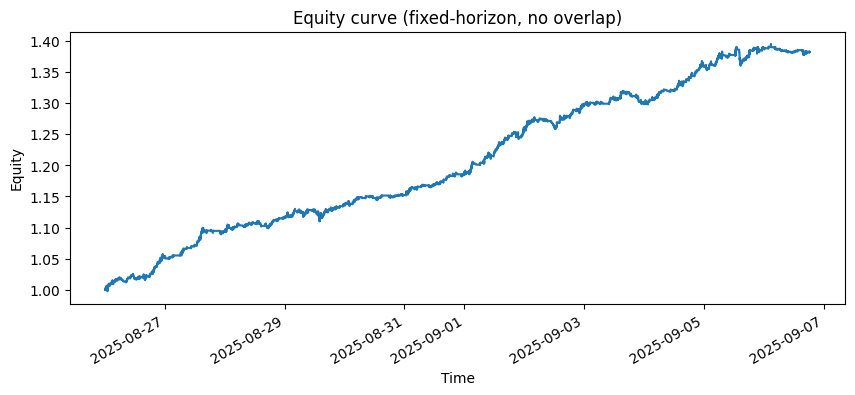

In [44]:
# Make sure price column is present (it should be already)
if "close" not in fdf.columns:
    fdf = fdf.join(df["close"], how="left")  # only if missing

# Run the safer, fixed-horizon backtest (no overlapping returns)
bt_safe, metr_safe = backtest_fixed_horizon(
    fdf.dropna(subset=["proba", "close"]),
    proba_col="proba",
    long_threshold=float(LONG_TH),
    short_threshold=float(SHORT_TH),   # 0.0 = long-only
    cost_bps=int(COST_BPS),
    slippage_bps=int(SLIP_BPS),
    hold_minutes=int(HORIZON_MIN),
)

print(metr_safe)

# Plot
import matplotlib.pyplot as plt
if len(bt_safe):
    plt.figure(figsize=(10,4))
    bt_safe["equity"].plot()
    plt.title("Equity curve (fixed-horizon, no overlap)")
    plt.xlabel("Time"); plt.ylabel("Equity")
    plt.show()
else:
    print("No bars in bt_safe.")


In [45]:
curve = bt_safe if 'bt_safe' in globals() else bt  # whichever you used
dd = curve['equity'] / curve['equity'].cummax() - 1
print("Max drawdown:", float(dd.min()))
trades = ((curve['pos'].shift(1)==0) & (curve['pos']!=0)).sum()
print("Entries:", int(trades))
daily = curve['equity'].resample('1D').last().pct_change().dropna()
print("Daily mean/std:", daily.mean(), daily.std())


Max drawdown: -0.02199417111051727
Entries: 618
Daily mean/std: 0.025332674711153434 0.019264374753209225
